# Segmentation adapter [B,L] with pkl

In [1]:
# !pip install Unidecode
# !pip install fuzzysearch

# !pip install elementpath
# !pip install lxml 
# !pip install graphviz
# !pip install pydotplus

In [1]:
!ls ../../../edspdf-train/data/publaynet/

dev.json xmls


In [1]:
import sys
sys.path.append('../')
import os
from pathlib import Path
import json
from sort_xml import *
import numpy as np
import pickle as pk

from edspdf import Pipeline
from edspdf.structures import Box, PDFDoc


base_dir = '../../../edspdf-train/data/publaynet/'

%load_ext autoreload
%autoreload 2

sys.executable

'/Users/souleymbaye/opt/anaconda3/envs/eds_env/bin/python'

In [2]:
# model
model = Pipeline()
model.add_pipe("pdfminer-extractor", config=dict(extract_style="true"), name="extractor")

In [14]:
# BL
import subprocess
import re
from edspdf.utils.alignment import align_box_labels_bl_pkl

xmls_dir = '../../../edspdf-train/data/publaynet/xmls/'
command = f'ls {xmls_dir}'
process = subprocess.run(command, shell=True, capture_output=True, text=True, encoding='utf-8', errors='ignore')
pmcs = process.stdout
pmcs = re.sub(r'\x1b\[.*?m', '', pmcs).splitlines()
for it,pmc in enumerate(pmcs[0:55]):
    pmc_dir = xmls_dir + ('/' if xmls_dir[-1]!='/' else '') + pmc
    print(f'\n------------------------\n{pmc}  -->  {1+it}/{len(pmcs)} pmc_dir {pmc_dir}')

    # load
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'rb') as file:
        pmc_data = pk.load(file)
    
    # break

    # boxes from pkl
    _boxes = pmc_data['body_lines'] # + loaded_pmc_data['front_lines'] + loaded_pmc_data['table_lines']
    
    pdf_path = pmc_data['pdf_path']
    pdf = Path(pdf_path).read_bytes()
    doc: PDFDoc = model.get_pipe("extractor")(pdf)
    
    #
    k = 100
    print(f'Before align\n{doc.content_boxes[k:k+10]}')
    print(set([tb.label for tb in doc.content_boxes]))
    #
    
    doc.content_boxes = [
        box_lines
        for box_lines in align_box_labels_bl_pkl(
            src_boxes=[
                Box(
                    page_num = tb['page_num'],
                    x0 = tb['x0'],
                    x1 = tb['x1'],
                    y0 = tb['y0'],
                    y1 = tb['y1'],
                    label = tb['bioul'],
                )
                for tb in _boxes
            ],
            dst_boxes=doc.content_boxes,
            pollution_label='pollution',
        )
        if box_lines.text == "" or box_lines.label is not None
    ]
    for tb in doc.content_boxes:
        if not tb.label:
            print('No label here')
    
    #
    print(f'After align\n{doc.content_boxes[k:k+10]}')
    break
    #


------------------------
PMC1087887  -->  1/103 pmc_dir ../../../edspdf-train/data/publaynet/xmls/PMC1087887
Before align
[TextBox(x0=0.5115686274509804, x1=0.9053223333333333, y0=0.4796265151515151, y1=0.49189924242424243, label=None, page_num=1, text='Typical clinical symptoms for VTE and unknown or equiv-', props=[TextProperties(italic=False, bold=False, begin=0, end=55, fontname='EFNLCB+Giovanni-Book')]), TextBox(x0=0.09009803921568636, x1=0.4838438039215687, y0=0.4944038787878786, y1=0.5066766060606058, label=None, page_num=1, text='low-up period until 2003, i.e., carefully reviewing', props=[TextProperties(italic=False, bold=False, begin=0, end=51, fontname='EFNLCB+Giovanni-Book')]), TextBox(x0=0.5115686274509804, x1=0.9052969215686277, y0=0.49439919696969703, y1=0.5066719242424242, label=None, page_num=1, text='ocal result on imaging, only suspicion of VTE suggested by', props=[TextProperties(italic=False, bold=False, begin=0, end=58, fontname='EFNLCB+Giovanni-Book')]), TextBox

In [22]:
# Type of lines

# load pkl_files
path = '../../../edspdf-train/data/publaynet/xmls/'
types_lines: list[str] = ['front', 'body', 'table']
command = f'ls {path}'
process = subprocess.run(command, shell=True, capture_output=True, text=True, encoding='utf-8', errors='ignore')
pmcs = process.stdout
pmcs = re.sub(r'\x1b\[.*?m', '', pmcs).splitlines()
print('Type segmentation adapter')
for it,pmc in enumerate(pmcs[0:54]):
    pmc_dir = path + pmc
    print(f'\n------------------------\n{pmc}  -->  {1+it}/{len(pmcs)} pmc_dir {pmc_dir}')

    # load
    pk_path = pmc_dir + '/' + 'pmc_data.pkl'
    with open(pk_path, 'rb') as file:
        pmc_data = pk.load(file)
    
    # break

    # boxes from pkl
    _boxes = []
    if 'front' in types_lines:
        _boxes.extend(pmc_data['front_lines'])
    if 'body' in types_lines:
        _boxes.extend(pmc_data['body_lines'])
    if 'table' in types_lines:
        _boxes.extend(pmc_data['table_lines'])
    # _boxes = pmc_data['front_lines'] + pmc_data['body_lines'] + pmc_data['table_lines']
    
    
    pdf_path = pmc_dir + '/' + pmc_data['pdf_path'].split('/')[-1]
    pdf = Path(pdf_path).read_bytes()
    doc: PDFDoc = model.get_pipe("extractor")(pdf)
    
    #
    k = 100
    print(f'Before align\n{doc.content_boxes[k:k+10]}')
    print(set([tb.label for tb in doc.content_boxes]))
    #
    
    doc.content_boxes = [
        box_lines
        for box_lines in align_box_labels_bl_pkl(
            src_boxes=[
                Box(
                    page_num = tb['page_num'],
                    x0 = tb['x0'],
                    x1 = tb['x1'],
                    y0 = tb['y0'],
                    y1 = tb['y1'],
                    label = tb['label'],
                )
                for tb in _boxes
            ],
            dst_boxes=doc.content_boxes,
            pollution_label='pollution',
        )
        if box_lines.text == "" or box_lines.label is not None
    ]
    for tb in doc.content_boxes:
        if not tb.label:
            print('No label here')
    
    #
    print(f'After align\n{doc.content_boxes[k:k+10]}')
    break
    #

Type segmentation adapter

------------------------
PMC1087887  -->  1/103 pmc_dir ../../../edspdf-train/data/publaynet/xmls/PMC1087887
Before align
[TextBox(x0=0.5115686274509804, x1=0.9053223333333333, y0=0.4796265151515151, y1=0.49189924242424243, label=None, page_num=1, text='Typical clinical symptoms for VTE and unknown or equiv-', props=[TextProperties(italic=False, bold=False, begin=0, end=55, fontname='EFNLCB+Giovanni-Book')]), TextBox(x0=0.09009803921568636, x1=0.4838438039215687, y0=0.4944038787878786, y1=0.5066766060606058, label=None, page_num=1, text='low-up period until 2003, i.e., carefully reviewing', props=[TextProperties(italic=False, bold=False, begin=0, end=51, fontname='EFNLCB+Giovanni-Book')]), TextBox(x0=0.5115686274509804, x1=0.9052969215686277, y0=0.49439919696969703, y1=0.5066719242424242, label=None, page_num=1, text='ocal result on imaging, only suspicion of VTE suggested by', props=[TextProperties(italic=False, bold=False, begin=0, end=58, fontname='EFNLCB+

In [21]:
pmc_data['body_lines']

[{'x0': 0.09009803921568628,
  'x1': 0.18863402941176471,
  'y0': 0.10849772727272733,
  'y1': 0.12205833333333338,
  'label': 'title',
  'page_num': 1,
  'text': 'Background',
  'props': [{'italic': False,
    'bold': True,
    'begin': 0,
    'end': 10,
    'fontname': 'EFNLBB+GillSans-Bold'}],
  'node_type': 'body',
  'node_num': 0,
  'rank': 0,
  'bioul': 'B',
  'table_num': None},
 {'x0': 0.09009803921568628,
  'x1': 0.48383268627450976,
  'y0': 0.12349015151515152,
  'y1': 0.13576287878787885,
  'label': 'p',
  'page_num': 1,
  'text': 'Internationally there are several models available to assess',
  'props': [{'italic': False,
    'bold': False,
    'begin': 0,
    'end': 60,
    'fontname': 'EFNLCB+Giovanni-Book'}],
  'node_type': 'body',
  'node_num': 0,
  'rank': 1,
  'bioul': 'I',
  'table_num': None},
 {'x0': 0.09009803921568628,
  'x1': 0.48385333333333347,
  'y0': 0.13833892424242422,
  'y1': 0.15061165151515155,
  'label': 'p',
  'page_num': 1,
  'text': 'the long-term r

## Display pdf(show annotation) with the loaded pkl file

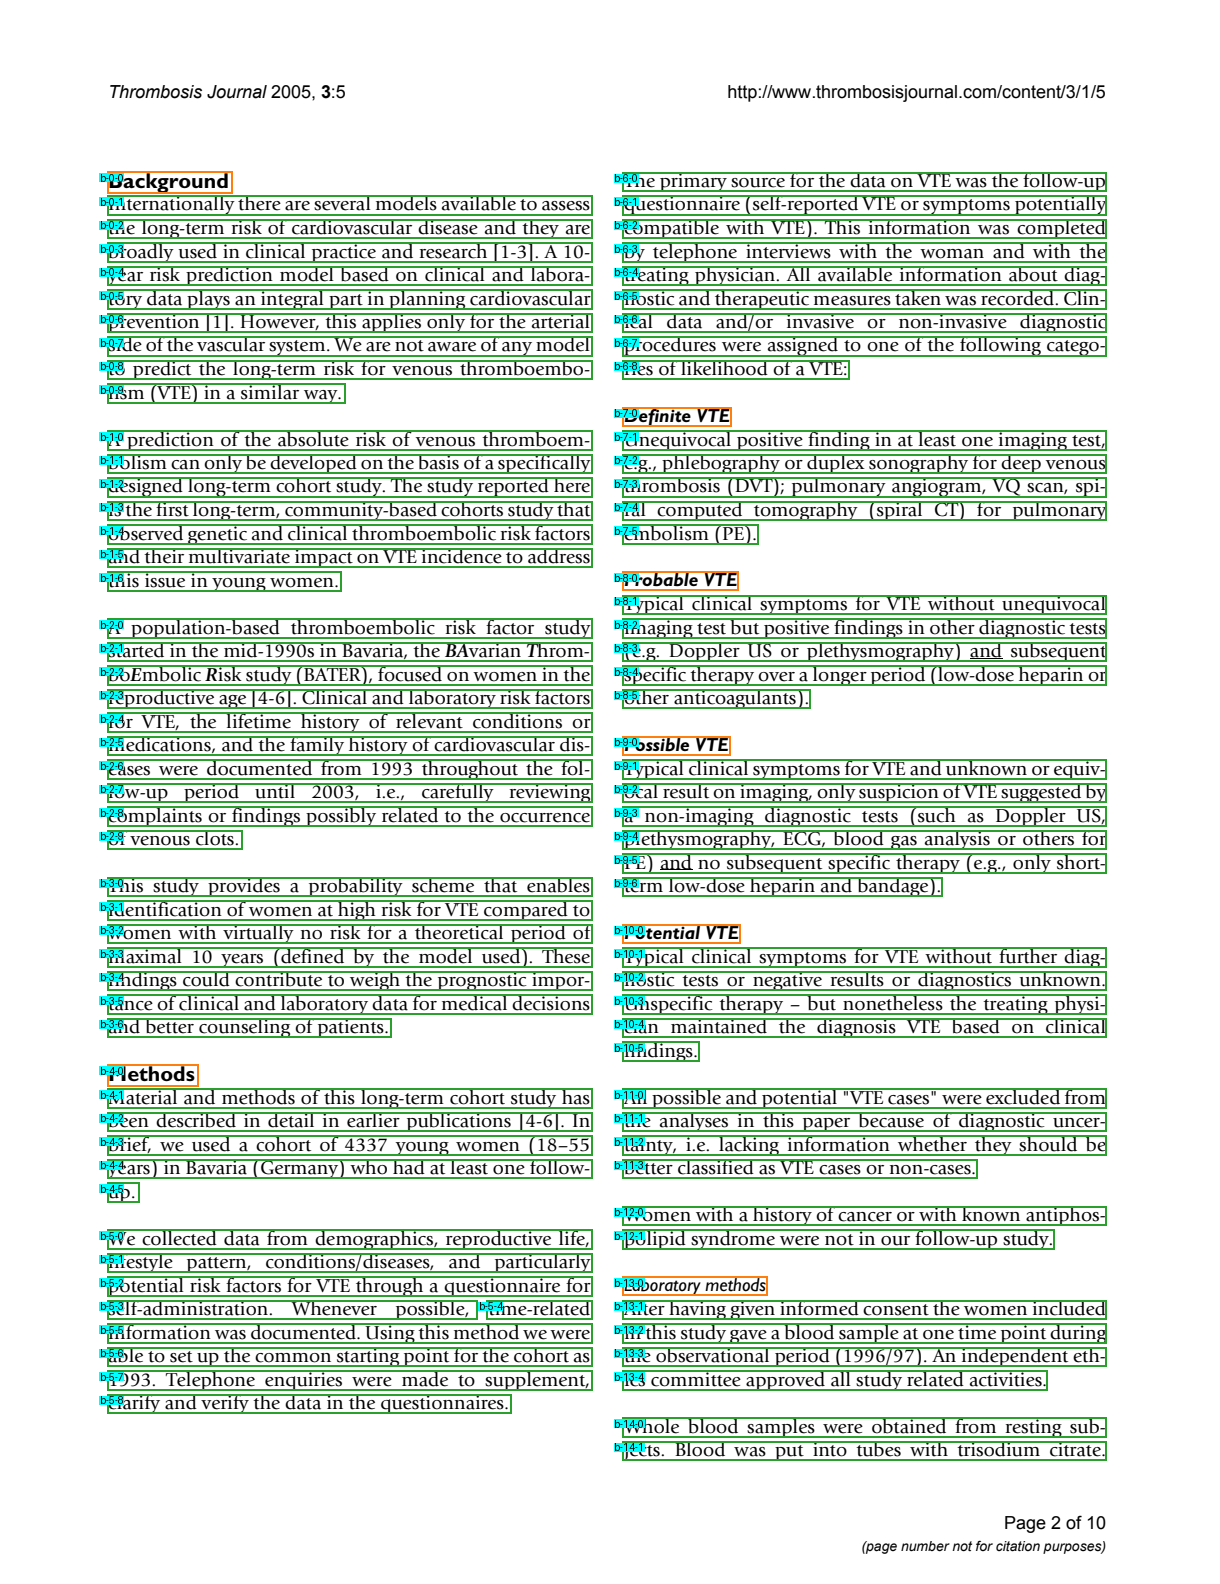

In [13]:
from edspdf.structures import Box, Box_lines, TextBox
from edspdf.visualization.annotations import show_annotations

pdf = Path(pmc_data['pdf_path']).read_bytes()
doc_2: PDFDoc = model.get_pipe("extractor")(pdf)

content_boxes = []
for li in pmc_data['front_lines'] + pmc_data['body_lines'] + pmc_data['table_lines']:
    _tb = TextBox(
        x0=li['x0'],
        x1=li['x1'],
        y0=li['y0'],
        y1=li['y1'],
        text=li['text'],
        label=li['label'],
        page_num=li['page_num'],
        )
    if li['node_type'] == 'front':
        _tb.rank = f"{li['node_type'][0]}-{li['node_num']}-{li['rank']}"
        _tb.color='yellow'
        _tb.bg_color='black'
    if li['node_type'] == 'body':
        _tb.rank = f"{li['node_type'][0]}-{li['node_num']}-{li['rank']}"
        _tb.color='black'
        _tb.bg_color='cyan'
    if li['node_type'] == 'table':
        _tb.rank = f"{li['node_type'][:2]}-{li['node_num']}-{li['rank']}"
        _tb.color='red'
        _tb.bg_color='white'
    content_boxes.append(_tb)

# for page in show_annotations(doc_2.content, content_boxes):
#     display(page)
display(show_annotations(doc_2.content, content_boxes)[1])